# Tutorial Ptychographic imaging
### Using HDF5 data loader in Ptypy

# Ptychographic phase retrieval using Ptypy

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) /  email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

##### Disclaimer: This notebook is intended for educational purposes only and should not be used for professional data analysis. For the latter, there are other more efficient and complete codes available.

# Ptypy - Ptychography for Python

<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://ptycho.github.io/ptypy/index.html"><img src="https://ptycho.github.io/ptypy/_static/logo_100px.png" width="100%"/></a>
  </td>
</table>

<span style="color:blue"> **For the installation instruction of Ptypy, please click here: [Ptypy installation](https://ptycho.github.io/ptypy/rst/getting_started.html#installation)** </span>

In [6]:
import os
import h5py
import numpy as np
import ptypy
from ptypy import io
from ptypy import utils as u

Let's first inspect the `.h5` file to see what it contains:

In [7]:
path_to_data = "SiemensStar.h5"
with h5py.File(path_to_data) as f:
    print("The file {} has the following relevant entries: \n".format(path_to_data))
    print('\n'.join('\t* {0:<30} shape = {1:}'.format(k,f[k].shape) for k in list(f)))

The file SiemensStar.h5 has the following relevant entries: 

	* data                           shape = (175, 256, 256)
	* det_distance_mm                shape = ()
	* det_pixelsize_um               shape = ()
	* energy_keV                     shape = ()
	* posx_um                        shape = (175,)
	* posy_um                        shape = (175,)


We should now import the `hdf5_loader` class

In [8]:
# This will import the HDF5Loader Class
ptypy.load_ptyscan_module('hdf5_loader')

##### `Ptypy` is now using `CuPy` for the GPU-accelerated reconstructions
If you use GPUs in the calculations, you need to import the `CuPy`-based routines: 

In [32]:
### This will import the GPU engines
# ptypy.load_gpu_engines("cupy")  # uncomment it if you plan to use GPUs

We create the empty root parameter tree `p`. Then, we set `verbose_level` to `interactive` which is adapted for Jupyter notebooks since it gives a more condensed user output. 

In [9]:
## General parameter container
p = u.Param()
p.verbose_level = "interactive" # "info"						## Verbosity level

Now we need to create the subtree for input/output related paramters. For this particular example, we don't save any file and turn off autoplotting

In [10]:
p.run = "SiemensStar"						## Reconstruction identifier
## Global parameters for I/O
p.io = u.Param()
p.io.home = "./" 						## Base directory for all I/O
p.io.rfile = "recons2/%(run)s/%(run)s_%(engine)s.ptyr" ## Reconstruction file name (or format string)
p.io.autosave = u.Param(active=False)  ## Auto-save options
p.io.interaction = u.Param(active=False)
#p.io.interaction = u.Param(active=True)
#p.io.interaction.server = u.Param()
#p.io.interaction.server.port = 5580
#p.io.interaction.server.address = "tcp://127.0.0.1"

# Live-plotting during the reconstruction
#p.io.autoplot = u.Param(active=False)  ## Plotting client parameters
p.io.autoplot = u.Param()
p.io.autoplot.active=True
p.io.autoplot.threaded = False
p.io.autoplot.layout = "jupyter"
p.io.autoplot.interval = 1

Let's define the subtree for the scan parameters

In [11]:
## Scan parameters
p.scans = u.Param() ## param container for instances of scan parameters
p.scans.FAMEPIX = u.Param()
p.scans.FAMEPIX.name = "Full" #"BlockFull"  or "Full"
p.scans.FAMEPIX.propagation = "farfield"  ## Propagation type: "nearfield" or "farfield"

Now, we declared where the data is

In [12]:
# Data parameters
p.scans.FAMEPIX.data= u.Param() ## Data preparation parameters
p.scans.FAMEPIX.data.name = 'Hdf5Loader'

# Read diffraction data
p.scans.FAMEPIX.data.intensities = u.Param()
p.scans.FAMEPIX.data.intensities.file = path_to_data
p.scans.FAMEPIX.data.intensities.key = 'data'

# Read positions data
p.scans.FAMEPIX.data.positions = u.Param()
p.scans.FAMEPIX.data.positions.file = path_to_data
p.scans.FAMEPIX.data.positions.slow_key = "posy_um"
p.scans.FAMEPIX.data.positions.slow_multiplier = 1e-6
p.scans.FAMEPIX.data.positions.fast_key = "posx_um"
p.scans.FAMEPIX.data.positions.fast_multiplier = 1e-6

# Read meta data: photon energy
p.scans.FAMEPIX.data.recorded_energy = u.Param()
p.scans.FAMEPIX.data.recorded_energy.file = path_to_data
p.scans.FAMEPIX.data.recorded_energy.key = "energy_keV"
p.scans.FAMEPIX.data.recorded_energy.multiplier = 1

# Read meta data: detector distance
p.scans.FAMEPIX.data.recorded_distance = u.Param()
p.scans.FAMEPIX.data.recorded_distance.file = path_to_data
p.scans.FAMEPIX.data.recorded_distance.key = "det_distance_mm"
p.scans.FAMEPIX.data.recorded_distance.multiplier = 1e-3

# Read meta data: detector pixelsize
p.scans.FAMEPIX.data.recorded_psize = u.Param()
p.scans.FAMEPIX.data.recorded_psize.file = path_to_data
p.scans.FAMEPIX.data.recorded_psize.key = "det_pixelsize_um"
p.scans.FAMEPIX.data.recorded_psize.multiplier = 1e-6

There is the new and yet undocumented parameter `resolution`, which should be used for spectral ptychography, for example, to obtain images with the same pixel size for all the energies used:

In [13]:
######## Parameter resolution
#p.scans.FAMEPIX.resolution = 5e-9

We also have to tell how the illumination is

In [14]:
### calculation of the effective distance (Fresnel Scaling Theorem)
ptydfile=io.h5read('SiemensStar.ptyd','info')['info']
sx = ptydfile['sx']
focus_position = ptydfile['sx0']
z12 = ptydfile['distance']
z1 = np.abs(sx-focus_position)
z2 = z12-z1
dist_parallel = z1*z2/z12

# Illumination parameters
p.scans.FAMEPIX.illumination = u.Param()
p.scans.FAMEPIX.illumination.aperture = u.Param() ## Beam aperture parameters
p.scans.FAMEPIX.illumination.aperture.form = "rect" ## One of None, 'rect' or 'circ'
p.scans.FAMEPIX.illumination.aperture.size = 120e-6 ## Aperture width or diameter
p.scans.FAMEPIX.illumination.propagation=u.Param() ## Parameters for propagation 
p.scans.FAMEPIX.illumination.propagation.parallel = dist_parallel
p.scans.FAMEPIX.illumination.propagation.focussed = 0.1 
p.scans.FAMEPIX.illumination.model = None
p.scans.FAMEPIX.illumination.recon = None

Since the illumination can suffer from partial coherence effects, we decompose the probe in orthogonal modes to try to take the effects into account

In [15]:
p.scans.FAMEPIX.illumination.diversity = u.Param()
p.scans.FAMEPIX.illumination.diversity.power = 0.1
p.scans.FAMEPIX.illumination.diversity.noise = (1,2)
## coherence parameters
p.scans.FAMEPIX.coherence = u.Param()
p.scans.FAMEPIX.coherence.num_probe_modes = 3 ## Number of probe modes
p.scans.FAMEPIX.coherence.num_object_modes = 1 ## Number of object modes

We can also initialize the object function

In [16]:
## Object initiation parameters
p.scans.FAMEPIX.sample= u.Param() ## initial object modelization parameters
p.scans.FAMEPIX.sample.model = None ## None, 'recon', 'stxm'
p.scans.FAMEPIX.sample.recon = None
p.scans.FAMEPIX.sample.fill = 1.0 + 1j * 0.0 # Default fill value

Finally, we need to define one (or more) reconstruction engines which specify which ptychographic algorithm(s) should be used in the reconstruction. 

In [33]:
p.engines = u.Param()

## First engine = DM
p.engines.engine00 = u.Param()
p.engines.engine00.name = "DM"   ## Engine name
# p.engines.engine00.name = "DM_cupy"   ## Use this one with GPUs
p.engines.engine00.numiter = 100         
p.engines.engine00.numiter_contiguous = 1       
p.engines.engine00.probe_support = None        
p.engines.engine00.alpha = 1                     
p.engines.engine00.probe_update_start = 2         
p.engines.engine00.update_object_first = True     
p.engines.engine00.overlap_converge_factor = 0.02 
p.engines.engine00.overlap_max_iterations = 100   
p.engines.engine00.probe_inertia = 0.01           
p.engines.engine00.object_inertia = 0.1           
p.engines.engine00.fourier_relax_factor = 0.02    
p.engines.engine00.obj_smooth_std = 5            
p.engines.engine00.clip_object = (0.,1.2)    

## Second engine = ML
p.engines.engine01 = u.Param()  
p.engines.engine01.name = 'ML'  ## Engine name
# p.engines.engine01.name = "ML_cupy"   ## Use this one with GPUs
p.engines.engine01.numiter = 30         
p.engines.engine01.numiter_contiguous = 1        
p.engines.engine01.ML_type = "gaussian"             
p.engines.engine01.probe_support = None          
p.engines.engine01.floating_intensities = True   
p.engines.engine01.intensity_renormalization = 1 
p.engines.engine01.smooth_gradient = 1          
p.engines.engine01.scale_precond = True          
p.engines.engine01.probe_update_start = 2        

At the end of our script (notebook) we can create a `ptypy.core.Ptycho` object by passing the parameter tree `p` and `level=5` which initialises everything and starts the reconstruction.

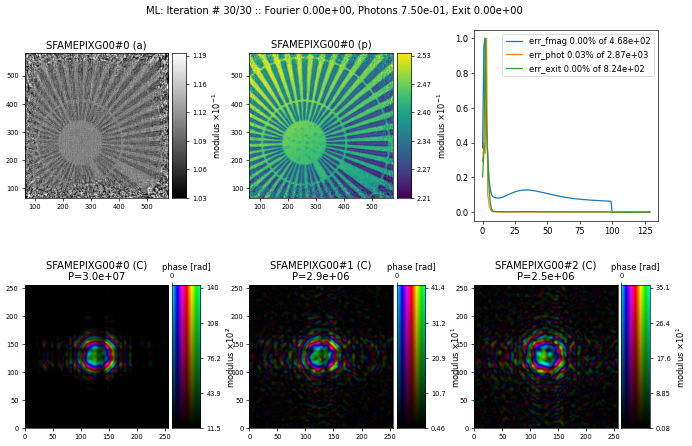


==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The difference map reconstruction algorithm:
    Thibault et al., "Probe retrieval in ptychographic coherent diffractive imaging" Ultramicroscopy 109 (2009) 338, doi: 10.1016/j.ultramic.2008.12.011.
The maximum likelihood reconstruction algorithm:
    Thibault P. and Guizar-Sicairos M., "Maximum-likelihood refinement for coherent diffractive imaging" New Journal of Physics 14 (2012) 63004, doi: 10.1088/1367-2630/14/6/063004.


<Figure size 640x480 with 0 Axes>

In [20]:
P = ptypy.core.Ptycho(p,level=5)

# Visualization from the reconstructed image file
If you want to quick look at the reconstructed image from the file:

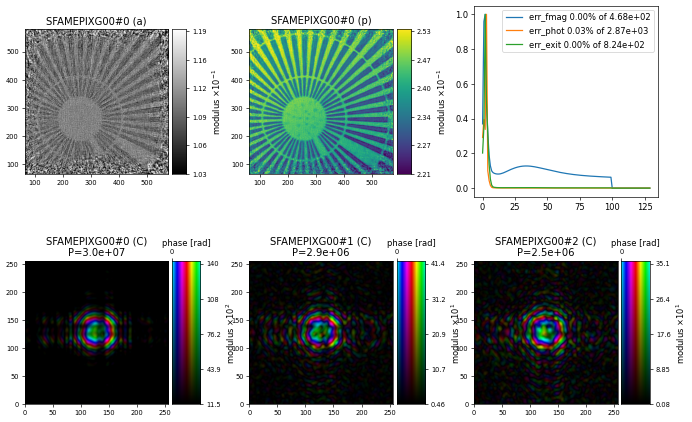

In [22]:
import os
import ptypy.utils.plot_client as pc
ptyr_filename = os.path.join(p.io.home, "recons2/SiemensStar/SiemensStar_ML.ptyr")
#layout = pc.TEMPLATES["weak"]
layout = pc.TEMPLATES["jupyter"]
fig = pc.figure_from_ptyr(ptyr_filename, pars=layout)
#fig = pc.figure_from_ptycho(P, pars=layout)

In [23]:
print('The array size of the reconstructed object image is:{}'.format(P.obj.S['SFAMEPIXG00'].shape))

The array size of the reconstructed object image is:(1, 646, 638)


In [24]:
print('The pixel size of the reconstructed image is: {:.01f} nm'.format(P.probe.S['SFAMEPIXG00'].psize[0]/1e-9))

The pixel size of the reconstructed image is: 10.0 nm


### Done. You have finished the job!

### If you have used mixed-state algorithms, you can proceed
As we can see above, the mixed-state algorithms in PtyPy provide different probe modes without constraining them on any basis. However, in order to interpret something from these probe modes, we need to provide a basis, with the most common choice being the enforcement of an orthonormal relationship between each mode. Ptypy’s ortho function will ortho-normalize the probe modes that we can extract from the probe

In [25]:
e,v = ptypy.utils.ortho(P.probe.S["SFAMEPIXG00"].data)

and returns the eigenvalues `e` and eigenvectors `v`. We can now use look at the orthonormalised probe modes and their corresponding relative power by making a matplotlib figure

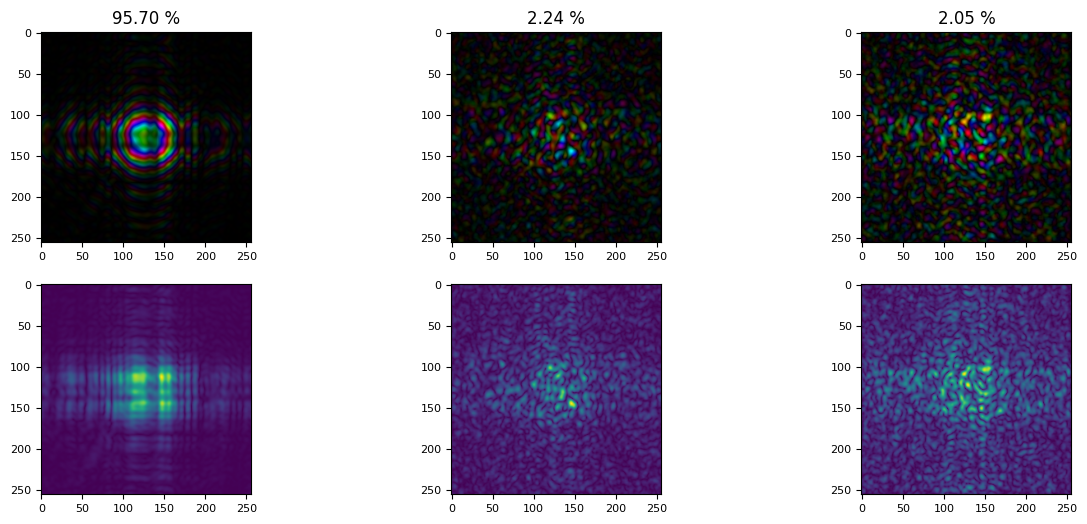

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(15,6))
for i in range(3):
    axes[0,i].set_title("{:.2f} %".format(e[i]*100.))
    ax1 = ptypy.utils.PtyAxis(axes[0,i],channel="c")
    ax1.set_data(v[i])
    ax2 = ptypy.utils.PtyAxis(axes[1,i],channel="a")
    ax2.set_data(v[i])

#### Inspecting the exit waves:

In [27]:
exit_wave0000 = P.pods['P0000'].exit
pod = P.pods['P0000']
# P.pods['P0000'].ex_view.data

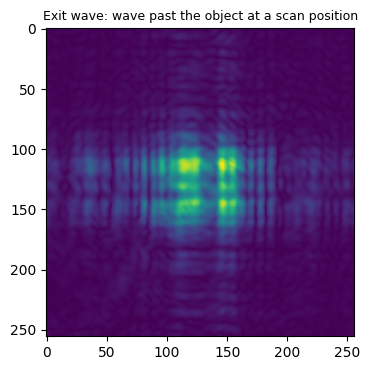

In [28]:
plt.figure(figsize=(4,4))
plt.imshow(np.abs(pod.probe * pod.object))
plt.axis('image')
plt.title('Exit wave: wave past the object at a scan position', fontsize=9)
plt.show()

In [29]:
#### Comparing the experimental and reconstructed diffraction patterns

In [30]:
diff = P.diff.views['V0000'].data # experimental data 
df = pod.fw(pod.probe * pod.object) # reconstructed one

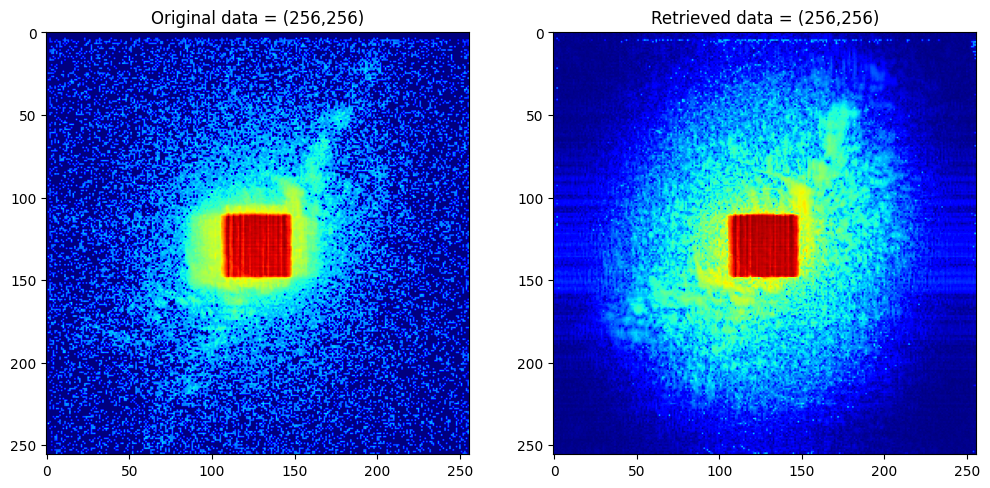

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.imshow(np.log(np.abs(diff)+0.02),cmap='jet')
ax1.set_title('Original data = ({:d},{:d})'.format(df.shape[0],df.shape[1]))
ax2 = fig.add_subplot(122)
ax2.imshow(np.log(np.abs(df)+0.02),cmap='jet')
ax2.set_title('Retrieved data = ({:d},{:d})'.format(diff.shape[0],diff.shape[1]))
fig.show()